In [1]:
from common import *

In [2]:
WORK_ROOT = '/home/ilc/bliewert/jobresults/analysis'

analysis = AnalysisChannel('550-hh-fast', zhh_cuts('llhh'))
analysis.initialize(WORK_ROOT, trees=['FinalStates', 'EventObservablesLL', 'KinFitLLNMC', 'KinFitLLZHH', 'KinFitLLZZH', 'KinFitLLZZZ'])

rf = analysis.rf
tree = rf['Merged']

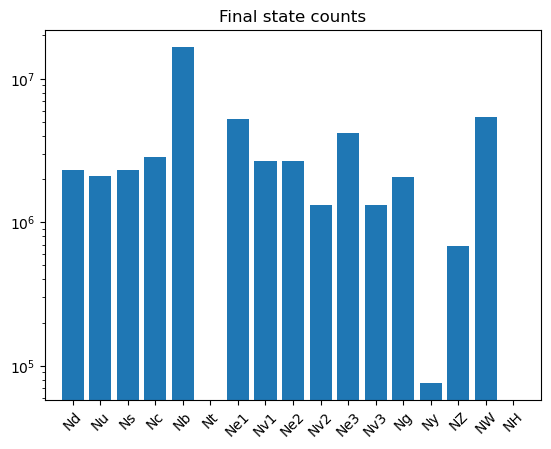

In [3]:
plot_counts(tree)

In [4]:
analysis.fetch('ll')
data = analysis.summary

# calculate and apply weights
weights, processes = analysis.weight()

Process e1e1hh       with Pol eL.pL has    328911 events xsec=5.121E-04 wt=9.809E-07
Process e1e1hh       with Pol eL.pR has    330967 events xsec=1.319E-02 wt=4.662E-05
Process e1e1hh       with Pol eR.pL has    329160 events xsec=8.317E-03 wt=1.769E-06
Process e1e1hh       with Pol eR.pR has    331409 events xsec=5.121E-04 wt=2.009E-07
Process e2e2hh       with Pol eL.pR has    331258 events xsec=1.266E-02 wt=4.472E-05
Process e2e2hh       with Pol eR.pL has    331278 events xsec=8.107E-03 wt=1.713E-06
Process e3e3hh       with Pol eL.pR has    326178 events xsec=1.263E-02 wt=4.531E-05
Process e3e3hh       with Pol eR.pL has    328044 events xsec=8.088E-03 wt=1.726E-06
Process n1n1hh       with Pol eL.pR has    336394 events xsec=4.074E-02 wt=1.417E-04
Process n1n1hh       with Pol eR.pL has    336322 events xsec=1.601E-02 wt=3.331E-06
Process n23n23hh     with Pol eL.pR has    326534 events xsec=5.006E-02 wt=1.794E-04
Process n23n23hh     with Pol eR.pL has    330643 events xsec=3.2

In [5]:
from zhh import combined_cross_section
combined_cross_section(processes, ['e1e1hh', 'e2e2hh', 'e3e3hh'])

0.023564424570940903

In [6]:
# TODO:
# class LazilyLoadedObject

from collections.abc import Callable
import abc

class FinalState:
    __metaclass__ = abc.ABCMeta
    
    def __init__(self, name:str, definition:Callable[[dict[str, np.ndarray]], np.ndarray]):
        self._name = name
        self._definition = definition
    
    def evaluate(self, tree:ur.WritableTree):
        return self._definition(self.finalStateWrapper(tree))
    
    @abc.abstractmethod
    def finalStateWrapper(self, tree:ur.WritableTree):
        counts = np.array(tree['final_state_counts.second'].array(), dtype='B')
        
        result = {
            'process': np.array(tree['process'].array(), dtype='I'),
            'n_d': counts[:, 0],
            'n_u': counts[:, 1],
            'n_s': counts[:, 2],
            'n_c': counts[:, 3],
            'n_b': counts[:, 4],
            'n_t': counts[:, 5],
            'n_b_from_higgs': np.array(tree['n_b_from_higgs'].array(), dtype='B'),
            'n_higgs': np.array(tree['n_higgs'].array(), dtype='B'),
        }
        
        result['n_q'] = result['n_d'] + result['n_u'] + result['n_s'] + result['n_c'] + result['n_b'] + result['n_t']
        result['n_v'] = counts[:, 7] + counts[:, 9] + counts[:, 11]
        result['n_e'] = counts[:, 6]
        result['n_mu'] = counts[:, 8]
        result['n_tau'] = counts[:, 10]
        result['n_charged_lep'] = result['n_e'] + result['n_mu'] + result['n_tau']
        
        return result
    
    @abc.abstractmethod
    def calcCrossSection(self, processes:np.ndarray, tree:ur.WritableTree):
        pass
    
    @abc.abstractmethod
    def calcExpectedEvents(self, tree:ur.WritableTree):
        pass # return self._definition(tree)
    
fs_llHH = FinalState('llHH', lambda fs_counts: (
    np.isin(fs_counts['process'], [ProcessCategories.e1e1hh, ProcessCategories.e2e2hh, ProcessCategories.e3e3hh])))
fs_llHH_llbbbb = FinalState('llHH(llbbbb)', lambda fs_counts: (fs_counts['n_b_from_higgs'] == 4) & (
    np.isin(fs_counts['process'], [ProcessCategories.e1e1hh, ProcessCategories.e2e2hh, ProcessCategories.e3e3hh])))
fs_llqqH = FinalState('llqqH', lambda fs_counts: (
    np.isin(fs_counts['process'], [ProcessCategories.e1e1qqh, ProcessCategories.e2e2qqh, ProcessCategories.e3e3qqh])))
        

In [7]:
# split into signal and background
pdgs = np.array(rf['Merged/final_state_counts.first'].array(entry_stop=1)[0])
print(pdgs)

counts = np.array(rf['Merged/final_state_counts.second'].array())
n_d = counts[:, 0]
n_u = counts[:, 1]
n_s = counts[:, 2]
n_c = counts[:, 3]
n_b = counts[:, 4]
n_t = counts[:, 5]
n_q = n_d + n_u + n_s + n_c + n_b + n_t

n_v = counts[:, 7] + counts[:, 9] + counts[:, 11]
n_e = counts[:, 6]
n_mu = counts[:, 8]
n_tau = counts[:, 10]
n_charged_lep = n_e + n_mu + n_tau
n_b_from_higgs = np.array(tree['n_b_from_higgs'].array(), dtype='B')

#sig = subset[subset['process']  > 0]
#bkg = subset[subset['process'] == 0]

#is_sig = np.isin(data['id'], sig['id'])
#is_bkg = np.isin(data['id'], bkg['id'])

data['is_sig'] = fs_llHH_llbbbb.evaluate(tree)
data['is_bkg'] = fs_llqqH.evaluate(tree)

print(f'Signal:Background = {data["is_sig"].sum()}:{data["is_bkg"].sum()}')

[ 1  2  3  4  5  6 11 12 13 14 15 16 21 22 23 24 25]


Signal:Background = 893461:2633008


In [8]:
assert(np.array(tree['error_code'].array()).sum() == 0)

In [9]:
#from phc import module_reload
#module_reload('zhh')

from zhh import calc_preselection_by_processes, apply_cuts, zhh_cuts
import numpy as np

from os.path import dirname, basename, splitext
from subprocess import run
from tabulate import tabulate, SEPARATING_LINE

def render_latex(latex:str, location:str):
    latex = latex.replace('_', '\\textunderscore ')
    latex = latex.replace('>=', '$\geq$')
    latex = latex.replace('<=', '$\leq$')
    
    content = "\documentclass[9pt]{article}\n\\usepackage[a4paper,margin=1in,landscape]{geometry}\n\\begin{document}\n " + latex + " \n\\end{document}"

    drn = dirname(location)
    se = splitext(basename(location))

    with open(f'{drn}/{se[0]}.tex', 'w') as f:
        f.write(content)
        
    run(['pdflatex', '-output-directory', drn, f'{drn}/{se[0]}.tex'])

In [10]:
from matplotlib.ticker import MultipleLocator
from phc import plot_hist, export_figures, set_colorpalette
from zhh import fig_ild_style, plot_preselection_by_event_categories, \
    calc_preselection_by_event_categories, plot_preselection_by_calc_dict, PlotContext, \
    Cut, WindowCut, LessThanEqualCut, GreaterThanEqualCut, EqualCut, zhh_cuts, \
    colorpalette_desy, annotate_cut, weighted_counts_by_categories, \
    plot_total_efficiency, plot_cut_efficiencies, annotate_cut, get_matplotlib_fonts

from zhh.plot.ild_style import ild_style_defaults
ild_style_defaults['fontname'] = ['Montserrat', 'Liberation Sans', 'Droid Sans']

plot_options = {
    'llbbbb': {
        'xx_nisoleps': { 'xlabel': 'IsoLeptons', 'plot_hist_kwargs': { 'int_bins': True },
                        'ild_style_kwargs': { 'xminor': False, 'xlocator': MultipleLocator(1), 'show_binning_on_y_scale': False, 'ild_text_position': 'upper right' } },
        'll_mz'      : { 'xlabel': 'm_{ll}', 'xlim': [40, 140], 'xunit': 'GeV' },
        'll_mh1'     : { 'xlabel': 'm_{H1}', 'xlim': [0, 250], 'xunit': 'GeV' },
        'll_mh2'     : { 'xlabel': 'm_{H2}', 'xlim': [0, 250], 'xunit': 'GeV' },
        'xx_pt_miss' : { 'xlabel': 'p_{t}^{miss}', 'xlim': [0, 200], 'xunit': 'GeV' },
        'xx_thrust'  : { 'xlabel': 'thrust' }
    },
    'vvbbbb': [
        { 'xlabel': 'IsoLeptons', 'plot_hist_kwargs': { 'int_bins': True }, 'ild_style_kwargs': { 'xminor': False, 'xlocator': MultipleLocator(1), 'show_binning_on_y_scale': False } },
        { 'xlabel': 'm_{H1}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H2}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'p_{t}^{miss}', 'xlim': [0, 200], 'xunit': 'GeV' },
        { 'xlabel': 'thrust' },
        { 'xlabel': 'E_{vis}' },
        { 'xlabel': 'm_{HH}', 'xunit': 'GeV' },
        { 'xlabel': 'bmax3' },
        None
    ],
    'qqbbbb': [
        { 'xlabel': 'IsoLeptons', 'plot_hist_kwargs': { 'int_bins': True }, 'ild_style_kwargs': { 'xminor': False, 'xlocator': MultipleLocator(1), 'show_binning_on_y_scale': False } },
        { 'xlabel': 'm_{H1}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H2}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'p_{t}^{miss}', 'xlim': [0, 200], 'xunit': 'GeV' },
        { 'xlabel': 'thrust' },
        { 'xlabel': 'bmax4' },
        None
    ]
}

In [11]:
from zhh import EventCategories, ProcessCategories

In [ ]:
EventCategories.eeHHbbbb

In [18]:
data['event_category'][data['process'] == ProcessCategories.e1e1hh] = EventCategories.eeHH
data['event_category'][data['process'] == ProcessCategories.e2e2hh] = EventCategories.µµHH
data['event_category'][data['process'] == ProcessCategories.e3e3hh] = EventCategories.𝜏𝜏HH

data['event_category'][(data['process'] == ProcessCategories.e1e1hh) & (data['Nb_from_H'] == 4)] = EventCategories.eeHHbbbb
data['event_category'][(data['process'] == ProcessCategories.e2e2hh) & (data['Nb_from_H'] == 4)] = EventCategories.µµHHbbbb
data['event_category'][(data['process'] == ProcessCategories.e3e3hh) & (data['Nb_from_H'] == 4)] = EventCategories.𝜏𝜏HHbbbb

data['event_category'][data['process'] == ProcessCategories.n1n1hh] = EventCategories.vvHH
data['event_category'][data['process'] == ProcessCategories.n23n23hh] = EventCategories.vvHH

data['event_category'][data['process'] == ProcessCategories.n1n1qqh] = EventCategories.vvqqH
data['event_category'][data['process'] == ProcessCategories.n23n23qqh] = EventCategories.vvqqH

# Fix backgrounds
data['event_category'][data['process'] == ProcessCategories.e1e1qqh] = EventCategories.llqqH
data['event_category'][data['process'] == ProcessCategories.e2e2qqh] = EventCategories.llqqH
data['event_category'][data['process'] == ProcessCategories.e3e3qqh] = EventCategories.llqqH

data['event_category'][data['process'] == ProcessCategories.qqqqh] = EventCategories.qqqqH

Processing <Cut on nisoleps >= 2> before: 8643001 after: 3653868


  0%|          | 0/7 [00:00<?, ?it/s]

Processing <Cut on 71.2 <= m_{Z} <= 111.2> before: 3653868 after: 2045688


  0%|          | 0/7 [00:00<?, ?it/s]

Processing <Cut on 60.0 <= m_{H1} <= 180.0> before: 2045688 after: 1964252


  0%|          | 0/7 [00:00<?, ?it/s]

Processing <Cut on 60.0 <= m_{H2} <= 180.0> before: 1964252 after: 1855688


  0%|          | 0/7 [00:00<?, ?it/s]

Processing <Cut on p_{t}^{miss} <= 70.0> before: 1855688 after: 1753889


  0%|          | 0/7 [00:00<?, ?it/s]

Processing <Cut on thrust <= 0.9> before: 1753889 after: 1746947


  0%|          | 0/7 [00:00<?, ?it/s]

/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-matplotlib/3.9.2-es64w5/lib/python3.11/site-packages/matplotlib/ticker.py:2926: RuntimeWarning: divide by zero encountered in scalar divide
  minorstep = majorstep / ndivs
/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-matplotlib/3.9.2-es64w5/lib/python3.11/site-packages/matplotlib/ticker.py:2932: RuntimeWarning: invalid value encountered in multiply
  locs = (np.arange(tmin, tmax) * minorstep) + t0


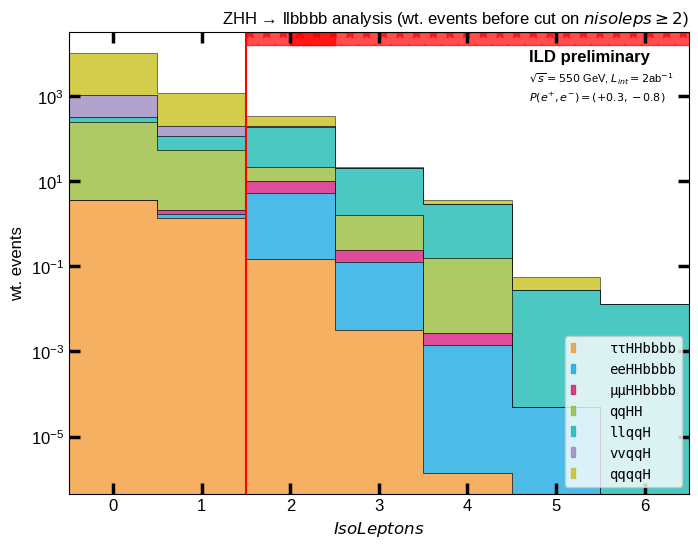

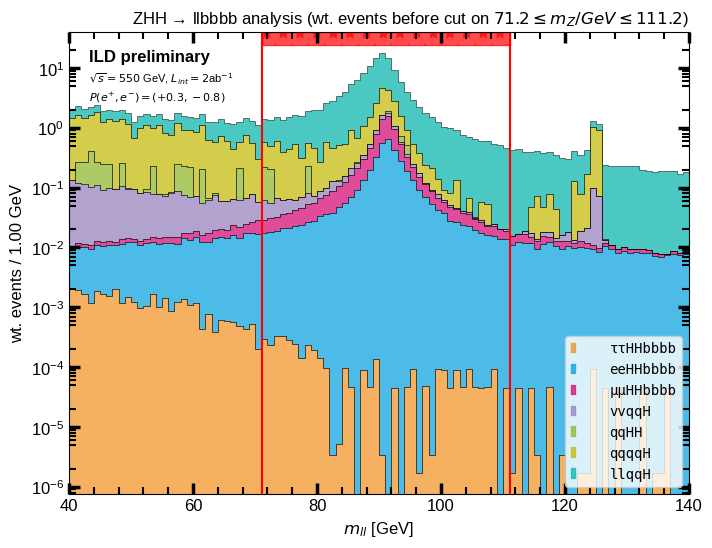

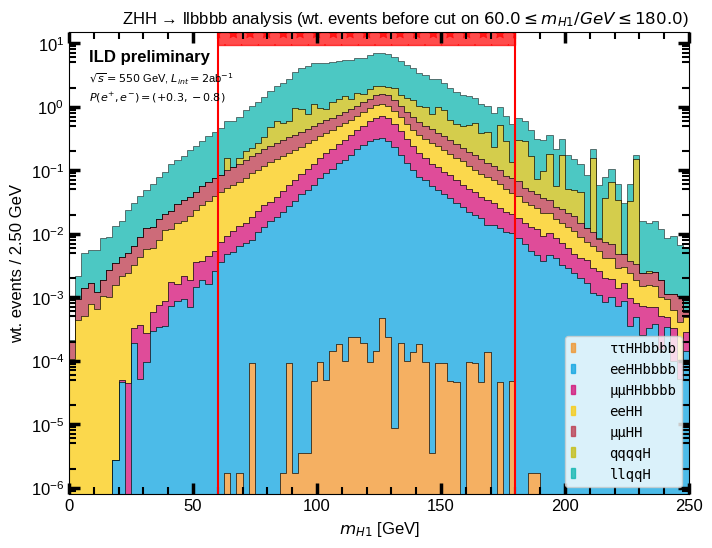

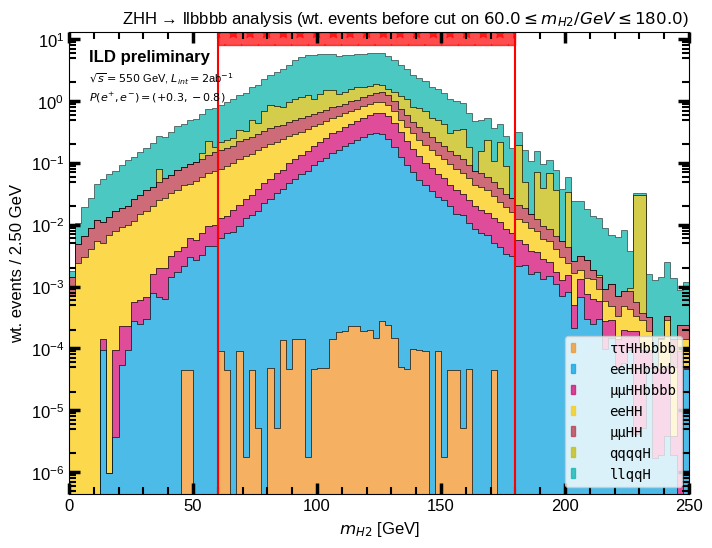

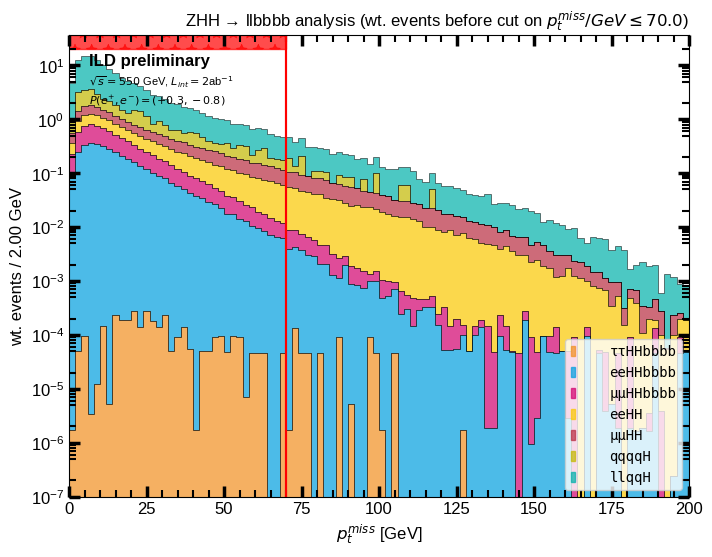

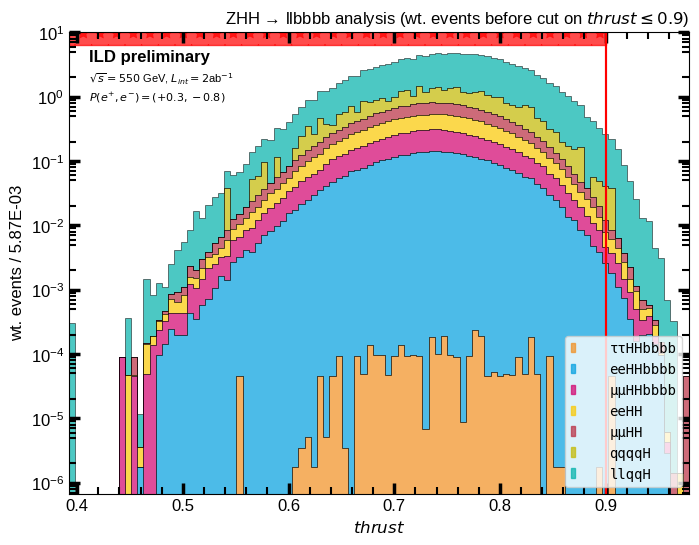

In [19]:
from phc import module_reload
module_reload('zhh')

from zhh import calc_preselection_by_event_categories, plot_preselection_by_calc_dict, annotate_cut

def extract_weights(calc_dict:dict):
    weights = {}
    for key in calc_dict:
        weights[key] = np.sum(calc_dict[key][1])
    
    return weights

def reorder_dict(some_dict, order:list[str]=[]):
    result = {}
    for key in order:
        if key in some_dict:
            result[key] = some_dict[key]
    
    for key in some_dict:
        if key not in order:
            result[key] = some_dict[key]
    
    return result

categories_selected = [
    EventCategories.𝜏𝜏HHbbbb,
    EventCategories.eeHHbbbb,
    EventCategories.µµHHbbbb
]
categories_selected_inv = [EventCategories.inverted[cat] for cat in categories_selected]
plot = True

# apply cuts
masks = []
figs = []
counts_all = []

subset = data
context = PlotContext(colorpalette_desy)
cuts = zhh_cuts('ll')

for i, cut in enumerate(cuts):
    mask = cut(subset)
    masks.append(np.isin(data['id'], subset['id'][mask]))
    
    print('Processing', cut, 'before:', len(subset), 'after:', mask.sum())
    
    if plot:
        calc_dict = calc_preselection_by_event_categories(subset, processes, processes,
                                                          categories_additional=4, categories_selected=categories_selected, quantity=cut.quantity)[0]
        
        counts_all.append(extract_weights(calc_dict))
        
        prefix, suffix, categories_additional, yscale_default = 'full', 'bbbb', 5, 'log'
        hypothesis = 'llbbbb'
        plot_kwargs = {
            'bins': 100,
            'xlabel': cut.quantity,
            'yscale': yscale_default,
            'plot_flat': False,
            'ild_style_kwargs': {},
            'plot_hist_kwargs': {},
            'plot_context': context
        } | (plot_options[hypothesis][i] if isinstance(plot_options[hypothesis], list) else plot_options[hypothesis][cut.quantity])
        plot_kwargs['ild_style_kwargs']['title_postfix'] = rf' before cut on ${cut.formula(unit=plot_kwargs["xunit"] if ("xunit" in plot_kwargs) else None)}$'

        fig = plot_preselection_by_calc_dict(reorder_dict(calc_dict, categories_selected_inv), hypothesis=hypothesis, **plot_kwargs)[0];
        annotate_cut(fig.axes[0], cut);
        figs += [fig]
        
    subset = subset[mask]
    
passed_presel_mask = np.isin(data['id'], subset['id'])

add = {}
for i, cat in enumerate(categories_selected):
    add[categories_selected_inv[i]] = subset['weight'][subset['event_category'] == cat].sum()
    
counts_all.append(add)

[0.028895142, 0.025849903, 0.99910986, 0.97660935, 0.8535579, 0.98597]
[0.9304705, 0.7609661, 0.9817734, 0.9891522, 0.99056745, 0.99851114]
[0.9248827, 0.95293593, 0.98099315, 0.98899335, 0.9912925, 0.9985878]


[<Figure size 1500x600 with 1 Axes>]

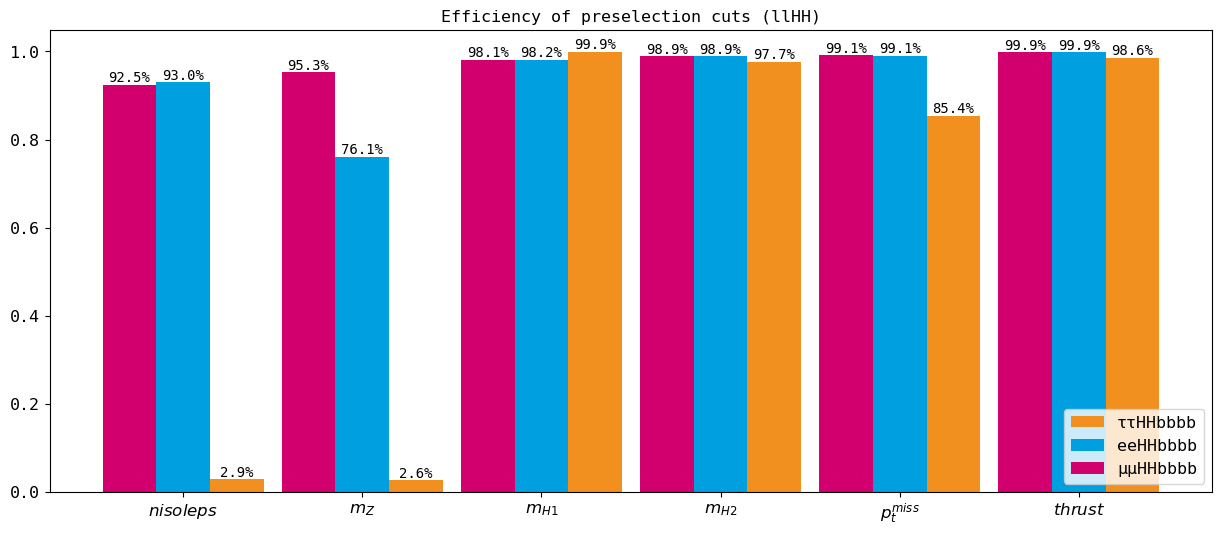

In [20]:
module_reload('zhh')
from zhh import plot_cut_efficiencies

plot_cut_efficiencies(counts_all, hypothesis='llHH', signal_categories=categories_selected_inv, cuts=cuts, plot_context=context)

In [75]:
sizes = {
    'bkg': int(0),
    'sig': int(0)
}

sources = [
    {
        'tree': tree,
        'event_category': data['event_category'],
        'mask': passed_presel_mask,
        'weights': data['weight']
    }
]
data_keys = tree.keys()

In [76]:
data_keys = set(data_keys) - set([
    'zhh_jet_matching',
    'EventObservablesLL_event',
    'EventObservablesLL_run',
    'bTags',
    'bTags2',
    'cTags',
    'cTags2',
    'cross_section',
    'errorCode',
    'error_code',
    'event_category',
    'event_category_zhh',
    'final_state_counts',
    'final_state_counts/final_state_counts.first',
    'final_state_counts/final_state_counts.second',
    'final_states',
    'n_b_from_higgs',
    'n_c_from_higgs',
    'n_fermion',
    'n_higgs',
    'polarization_code',
    'process',
    'process_id'
])

for kinfit in ['', 'KinFitLLZHH', 'KinFitLLZZH', 'KinFitLLZZZ']:
    prefix = f'{kinfit}_' if len(kinfit) else ''
    data_keys = data_keys - set([
        f'{prefix}run',
        f'{prefix}event',
        f'{prefix}BSEnergyTrue',
        f'{prefix}ISREnergyTrue',
        f'{prefix}TrueNeutrinoEnergy',
        f'{prefix}pullJetEnergy',
        f'{prefix}pullJetEnergy_woNu',
        f'{prefix}pullJetPhi',
        f'{prefix}pullJetPhi_woNu',
        f'{prefix}pullJetTheta',
        f'{prefix}pullJetTheta_woNu',
        f'{prefix}pullLeptonInvPt',
        f'{prefix}pullLeptonInvPt_woNu',
        f'{prefix}pullLeptonPhi',
        f'{prefix}pullLeptonPhi_woNu',
        f'{prefix}pullLeptonTheta',
        f'{prefix}pullLeptonTheta_woNu',
        
        f'{prefix}HHMassHardProcess',
        f'{prefix}pullLeptonTheta_woNu',
    ])

data_keys = list(data_keys)
data_keys.sort()

data_keys

['FitChi2',
 'FitChi2_woNu',
 'FitErrorCode',
 'FitErrorCode_woNu',
 'FitProbability',
 'FitProbability_woNu',
 'H1MassAfterFit',
 'H1MassAfterFit_woNu',
 'H1MassBeforeFit',
 'H1MassBeforeFit_woNu',
 'H2MassAfterFit',
 'H2MassAfterFit_woNu',
 'H2MassBeforeFit',
 'H2MassBeforeFit_woNu',
 'HHMassAfterFit',
 'HHMassAfterFit_woNu',
 'HHMassBeforeFit',
 'HHMassBeforeFit_woNu',
 'ISREnergyAfterFit',
 'ISREnergyAfterFit_woNu',
 'ISREnergyBeforeFit',
 'ISREnergyBeforeFit_woNu',
 'KinFitLLNMC_event',
 'KinFitLLNMC_run',
 'KinFitLLZHH_FitChi2',
 'KinFitLLZHH_FitChi2_woNu',
 'KinFitLLZHH_FitErrorCode',
 'KinFitLLZHH_FitErrorCode_woNu',
 'KinFitLLZHH_FitProbability',
 'KinFitLLZHH_FitProbability_woNu',
 'KinFitLLZHH_H1MassAfterFit',
 'KinFitLLZHH_H1MassAfterFit_woNu',
 'KinFitLLZHH_H1MassBeforeFit',
 'KinFitLLZHH_H1MassBeforeFit_woNu',
 'KinFitLLZHH_H2MassAfterFit',
 'KinFitLLZHH_H2MassAfterFit_woNu',
 'KinFitLLZHH_H2MassBeforeFit',
 'KinFitLLZHH_H2MassBeforeFit_woNu',
 'KinFitLLZHH_HHMassAfterFit

In [77]:
if os.path.isdir('plots/features'):
    shutil.rmtree('plots/features')

os.makedirs('plots/features', exist_ok=True)

In [104]:
data_type = 'float'
data_length = 0
features_to_skip = []

categories_selected_feat = categories_selected
feat_masks = []

for i, source in enumerate(sources):
    final_mask = source['mask'] & np.isin(source['event_category'], categories_selected_feat)
    feat_masks.append(final_mask)
    size = final_mask.sum()
    
    source['size'] = size
    data_length += size
    
category = np.zeros(data_length, dtype='B')
weights  = np.zeros(data_length, dtype=data_type)

pointer = 0
for i, source in enumerate(sources):
    feat_mask = feat_masks[i]
    
    category[pointer:(pointer+size)] = source['event_category'][feat_mask]
    weights [pointer:(pointer+size)] = source['weights'][feat_mask]
    
    pointer += source['size']

In [107]:
from tqdm.auto import tqdm
import awkward as ak

plt.ioff()

figures = []
hypothesis = 'llbbbb'
prefix, suffix, categories_additional, yscale_default = 'full', 'bbbb', 5, 'log'
    
if False:
    stats = np.zeros(len(data_keys), dtype=[
        ('id', 'B'),
        ('name', 'U64'),
        ('sig_mean', 'f8'),
        ('sig_std', 'f8'),
        ('sig_min', 'f8'),
        ('sig_max', 'f8'),
        ('bkg_mean', 'f8'),
        ('bkg_std', 'f8'),
        ('bkg_min', 'f8'),
        ('bkg_max', 'f8')
    ])
    stats['id'] = np.arange(len(data_keys))

counter = 0

for property in (pbar := tqdm(data_keys)):
    pbar.set_description(property)
    
    vector   = np.zeros(data_length, dtype=data_type)
    pointer = 0
    
    for i, source in enumerate(sources):
        tree, feat_mask, size = source['tree'], feat_masks[i], source['size']
        raw_array = source['tree'][property].array()
        
        if property in features_to_skip:
            continue
        elif len(ak.ravel(raw_array)) != len(raw_array): 
            features_to_skip.append(property)
            continue
        
        source_data = np.array(raw_array, dtype=data_type)
        
        vector  [pointer:(pointer+size)] = source_data[feat_mask]
        
        pointer += size
    
    # calculate statistics
    if False:
        wt_sig = (chunk_sig * weights_sig / weights_sig.sum())
        wt_bkg = (chunk_bkg * weights_bkg / weights_bkg.sum())
        
        stats['name'][counter] = property
        stats['sig_mean'][counter] = wt_sig.mean()
        stats['sig_std'][counter] = wt_sig.std()
        stats['sig_min'][counter] = wt_sig.min()
        stats['sig_max'][counter] = wt_sig.max()
        stats['bkg_mean'][counter] = wt_bkg.mean()
        stats['bkg_std'][counter] = wt_bkg.std()
        stats['bkg_min'][counter] = wt_bkg.min()
        stats['bkg_max'][counter] = wt_bkg.max()
            
        xlim = [
            min(chunk_sig.min(), chunk_bkg.min()),
            max(chunk_sig.max(), chunk_bkg.max())]
        
    calc_dict = {}
    for cat_idx in categories_selected_feat:
        project_out_mask = category == cat_idx
        calc_dict[EventCategories.inverted[cat_idx]] = [
            vector[project_out_mask],
            weights[project_out_mask]
        ]
    
    plot_kwargs = {
        'bins': 100,
        'xlabel': property,
        'yscale': yscale_default,
        'plot_flat': False,
        'ild_style_kwargs': {},
        'plot_hist_kwargs': {},
        'plot_context': context
    }

    fig = plot_preselection_by_calc_dict(reorder_dict(calc_dict, categories_selected_inv), hypothesis=hypothesis, **plot_kwargs)[0]
    
    figures.append(fig)
    counter += 1
    
export_figures('plots/features/inputs.pdf', figures)

plt.close('all')

  0%|          | 0/302 [00:00<?, ?it/s]

/gpfs/home/ilc/bliewert/DevRepositories/ZHH/zhhvenv/lib/python3.11/site-packages/phc/plot/plot_matplotlib.py:370: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left=xlim_view[0], right=xlim_view[1])
/gpfs/home/ilc/bliewert/DevRepositories/ZHH/zhhvenv/lib/python3.11/site-packages/phc/plot/plot_matplotlib.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-numpy/1.26.4-7ty7xd/lib/python3.11/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/cvmfs/sw.hsf.org/key4hep/releases

ValueError: Axis limits cannot be NaN or Inf

In [ ]:
data_type = 'float'
data_length = 0
features_to_skip = []

categories_selected_feat = categories_selected

for i, source in enumerate(sources):
    mask = source['mask']
    
    size_sig = int((mask & source['is_sig']).sum())
    size_bkg = int((mask & source['is_bkg']).sum())
    
    sources[i]['size_sig'] = size_sig
    sources[i]['size_bkg'] = size_bkg
    
    sizes['sig'] += size_sig
    sizes['bkg'] += size_bkg
    
    print(size_sig, size_bkg)

391238 734447


In [ ]:
from tqdm.auto import tqdm
import awkward as ak

plt.ioff()

figures = []
stats = np.zeros(len(data_keys), dtype=[
    ('id', 'B'),
    ('name', 'U64'),
    ('sig_mean', 'f8'),
    ('sig_std', 'f8'),
    ('sig_min', 'f8'),
    ('sig_max', 'f8'),
    ('bkg_mean', 'f8'),
    ('bkg_std', 'f8'),
    ('bkg_min', 'f8'),
    ('bkg_max', 'f8')
])
stats['id'] = np.arange(len(data_keys))
counter = 0

for property in (pbar := tqdm(data_keys)):
    pbar.set_description(property)
    chunk_sig = np.zeros(sizes['sig'], dtype='float')
    chunk_bkg = np.zeros(sizes['bkg'], dtype='float')
    
    weights_sig = np.zeros(sizes['sig'], dtype='float')
    weights_bkg = np.zeros(sizes['bkg'], dtype='float')
    
    pointer_sig = 0
    pointer_bkg = 0
    
    for source in sources:
        size_sig, size_bkg = source['size_sig'], source['size_bkg']
        raw_array = source['tree'][property].array()
        
        if property in features_to_skip:
            continue
        elif len(ak.ravel(raw_array)) != len(raw_array): 
            features_to_skip.append(property)
            continue
        
        source_data = np.array(raw_array, dtype=data_type)
        
        chunk_sig[pointer_sig:(pointer_sig+size_sig)] = source_data[source['mask'] & source['is_sig']]
        chunk_bkg[pointer_bkg:(pointer_bkg+size_bkg)] = source_data[source['mask'] & source['is_bkg']]
        
        weights_sig[pointer_sig:(pointer_sig+size_sig)] = source['weights'][source['mask'] & source['is_sig']]
        weights_bkg[pointer_bkg:(pointer_bkg+size_bkg)] = source['weights'][source['mask'] & source['is_bkg']]
        
        pointer_sig += size_sig
        pointer_bkg += size_bkg
    
    # calculate statistics
    wt_sig = (chunk_sig * weights_sig / weights_sig.sum())
    wt_bkg = (chunk_bkg * weights_bkg / weights_bkg.sum())
    
    stats['name'][counter] = property
    stats['sig_mean'][counter] = wt_sig.mean()
    stats['sig_std'][counter] = wt_sig.std()
    stats['sig_min'][counter] = wt_sig.min()
    stats['sig_max'][counter] = wt_sig.max()
    stats['bkg_mean'][counter] = wt_bkg.mean()
    stats['bkg_std'][counter] = wt_bkg.std()
    stats['bkg_min'][counter] = wt_bkg.min()
    stats['bkg_max'][counter] = wt_bkg.max()
        
    xlim = [
        min(chunk_sig.min(), chunk_bkg.min()),
        max(chunk_sig.max(), chunk_bkg.max())]
    
    fig = plot_hist({
        'Signal': chunk_sig,
        'Background': chunk_bkg
    }, normalize=True, xlim=xlim, yscale='log')#, weights={ 'Signal': weights_sig, 'Background': weights_bkg });
    
    fig_ild_style(fig, xlim=xlim, bins=64, xunit='', xlabel=property)
    
    figures.append(fig)
    counter += 1
    
export_figures('plots/features/inputs.pdf', figures)

In [ ]:
bmax_old = np.array([tree['bmax12'].array(), tree['bmax22'].array(), tree['bmax32'].array(), tree['bmax42'].array()]).T
bmax_new = np.array([tree['bmax1'].array(), tree['bmax2'].array(), tree['bmax3'].array(), tree['bmax4'].array()]).T

for idx in [0, 1, 2, 3]:
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
    for mask, title, ax in [
        (is_sig_4b, rf'Signal $ZHH \rightarrow llbbbb$', ax1),
        (is_bkg, rf'Background $ZZH \rightarrow llbbbb$', ax2)
    ]:
        mask = mask & (n_b == 4)
        ax.hist(bmax_new[mask, idx], bins=100, histtype='step', label=f'bmax{idx+1} NEW', color='red')
        ax.hist(bmax_old[mask, idx], bins=100, histtype='step', label=f'bmax{idx+1} OLD', color='blue')

        ax.set_title(title)
        ax.set_yscale('log')
        ax.legend()

In [57]:
features = ['evis', 'mzll', 'plmin', 'mbmax34', 'ptmiss', ('npfos', 'I'), 'mvalepminus']
names = []
dtypes = [('weight', 'f')] + []

for feat in features:
    if isinstance(feat, str):
        dtypes.append((feat, 'f'))
        names.append(feat)
    elif isinstance(feat, tuple):
        dtypes.append(feat)
        names.append(feat[0])

signal = np.zeros(len(sig), dtype=dtypes)
background = np.zeros(len(bkg), dtype=dtypes)

with ur.recreate('input.root') as file:
    for target, mask, treeName in (
        (signal, is_sig_and_passed, 'TreeS'),
        (background, is_bkg_and_passed, 'TreeB')
    ):
        target['weight'] = 1/len(target)
        
        for feat in names:
            target[feat] = np.array(rf[f'Merged/{feat}'].array())[mask]
        
        file[treeName] = target

In [14]:
from zhh import parse_polarization_code, sample_weight, ProcessCategories

In [15]:
ProcessCategories.inverted[1111]

'e1e1hh'

In [19]:
weights['weight'].sum()

19706.73

In [16]:
processes

array([(0, -1, -1, 0, 1.5881389e-02, 1790369, 5.5883871e-03),
       (1,  1,  1, 3, 2.4501428e-02,  994809, 3.2018062e-03),
       (2, -1, -1, 0, 5.1213225e-04, 1960368, 1.6458303e-04),
       (3,  1,  1, 3, 8.3169974e-03, 1976464, 5.4704241e-04),
       (4, -1, -1, 0, 1.9596890e+02,  492739, 2.5055945e+02),
       (5,  1,  1, 3, 7.3478470e+01,  320585, 2.9796158e+01)],
      dtype=[('pid', '<u2'), ('pol_e', '<i4'), ('pol_p', '<i4'), ('polarization_code', 'u1'), ('cross_sec', '<f4'), ('n_gen', '<u4'), ('weight', '<f4')])

In [50]:
mask_bkg.sum()

0

In [47]:
mask_sig.sum()

681589

(MH1, MH2) 0 entries = (0, 0)


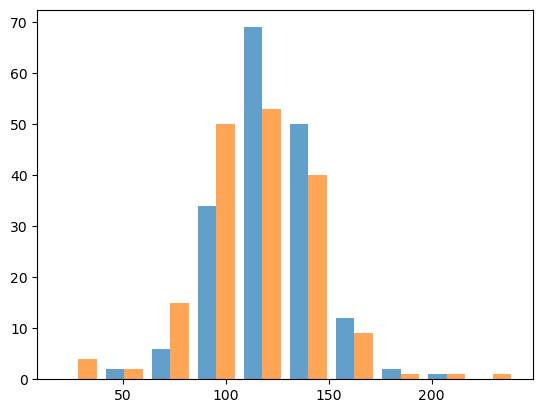

In [46]:
mode = 'LL_ZHH'
a = 'Boson2BeforeFit'
b = 'Boson2AfterFit'

mask = np.array(merged[f'EventObservablesLL/zhh_mz'].array() > 0)
err = np.array(merged[f'KinFit{mode}']['FitErrorCode'].array())
mask = (mask) #& (err == 0)

zhh_mh1 = np.array(merged[f'EventObservablesLL/zhh_mh1'].array())[mask]
zhh_mh2 = np.array(merged[f'EventObservablesLL/zhh_mh2'].array())[mask]

plt.hist([zhh_mh1, zhh_mh2], alpha=0.7)
print(f'(MH1, MH2) 0 entries = ({(zhh_mh1 == 0).sum()}, {(zhh_mh2 == 0).sum()})')

In [3]:
merged['FinalStates'].keys()

['run',
 'event',
 'error_code',
 'final_states',
 'final_state_counts',
 'final_state_counts/final_state_counts.first',
 'final_state_counts/final_state_counts.second',
 'process',
 'polarization_code',
 'cross_section',
 'event_category',
 'event_category_zhh',
 'n_fermion',
 'n_higgs',
 'n_b_from_higgs',
 'n_c_from_higgs']

In [5]:
merged['FinalStates/polarization_code'].array()

<Array [3, 3, 3, 3, 3, 3, 3, 3, ..., 0, 0, 0, 0, 0, 0, 0] type='198 * uint16'>

In [3]:
merged['FinalStates/final_state_counts/final_state_counts.first'].array(entry_stop=1)

<Array [[1, 2, 3, 4, 5, 6, ..., 16, 21, 22, 23, 24, 25]] type='1 * var * int32'>

In [4]:
# background: 2 leptons, 4 jets

In [5]:
merged['FinalStates/final_state_counts/final_state_counts.second'].array()

<Array [[0, 0, 0, 0, 4, 0, ..., 0, 0, 0, 0, 0], ...] type='198 * var * int32'>

In [6]:
np.isin(np.array(merged['FinalStates/process'].array()), [zhh.ProcessCategories.e1e1hh, zhh.ProcessCategories.e2e2hh]) & (np.array(merged['FinalStates/n_b_from_higgs'].array()) == 4)

array([ True, False,  True, False, False, False,  True,  True,  True,
       False, False,  True, False, False, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True,  True, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False,  True,  True,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True,  True, False, False,  True, False,  True,
        True, False,  True,  True,  True, False, False, False, False,
       False, False, False,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [7]:
#fsc = 
#merged['FinalStates']['n_higgs'].array() == 2

(Pre, Post) 0 entries = (0, 36)


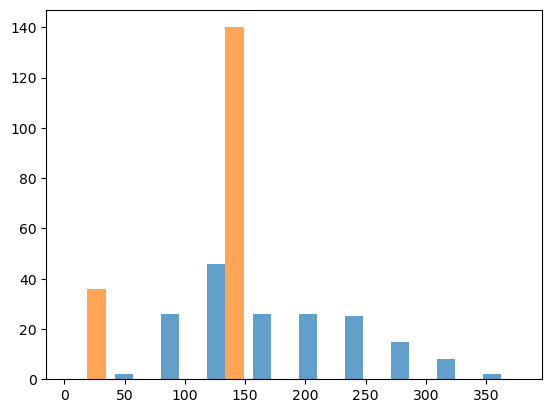

In [8]:
mode = 'LL_ZHH'
a = 'Boson2BeforeFit'
b = 'Boson2AfterFit'

mask = np.array(merged[f'KinFit{mode}']['nIsoLeptons'].array() == 2)
err = np.array(merged[f'KinFit{mode}']['FitErrorCode'].array())
mask = (mask) #& (err == 0)

preFit  = np.array(merged[f'KinFit{mode}'][a].array())[mask]
postFit = np.array(merged[f'KinFit{mode}'][b].array())[mask]

plt.hist([preFit, postFit], alpha=0.7)
print(f'(Pre, Post) 0 entries = ({(preFit == 0).sum()}, {(postFit == 0).sum()})')

(Pre, Post) 0 entries = (0, 17)


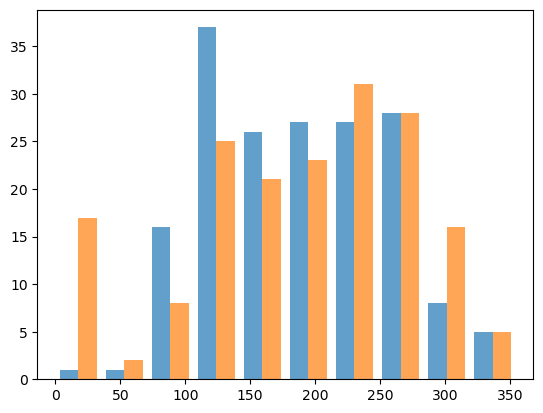

In [9]:
mode = 'LL_NMC'
a = 'Boson2BeforeFit'
b = 'Boson2AfterFit'

mask = np.array(merged[f'KinFit{mode}']['nIsoLeptons'].array() == 2)
err = np.array(merged[f'KinFit{mode}']['FitErrorCode'].array())
mask = (mask) #& (err == 0)

preFit  = np.array(merged[f'KinFit{mode}'][a].array())[mask]
postFit = np.array(merged[f'KinFit{mode}'][b].array())[mask]

plt.hist([preFit, postFit], alpha=0.7)
print(f'(Pre, Post) 0 entries = ({(preFit == 0).sum()}, {(postFit == 0).sum()})')

(array([17.,  2.,  8., 25., 21., 23., 31., 28., 16.,  5.]),
 array([  0.        ,  35.42832565,  70.85665131, 106.28498077,
        141.71330261, 177.14163208, 212.56996155, 247.99829102,
        283.42660522, 318.85494995, 354.28326416]),
 <BarContainer object of 10 artists>)

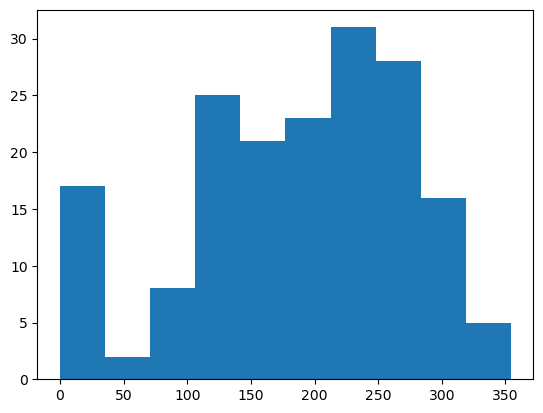

In [113]:
plt.hist(posFit)

In [66]:
np.unique(vals, return_counts=True)

<Array [[0, 1], [159, 17]] type='2 * var * int64'>

In [58]:
mask = np.array(merged[f'KinFit{ps}_ZHH']['nIsoLeptons'].array() == 2)
merged[f'KinFitLL_ZHH']['FitChi2'].array()[mask]
merged[f'KinFitLL_ZHH']['FitProbability'].array()[mask]

<Array [6.6e-25, 0, 3.94e-20, 0, ..., 0, 0, 0, 0] type='176 * float32'>

Text(0.5, 0.98, 'e2e2hh Events- ZHH KinFit')

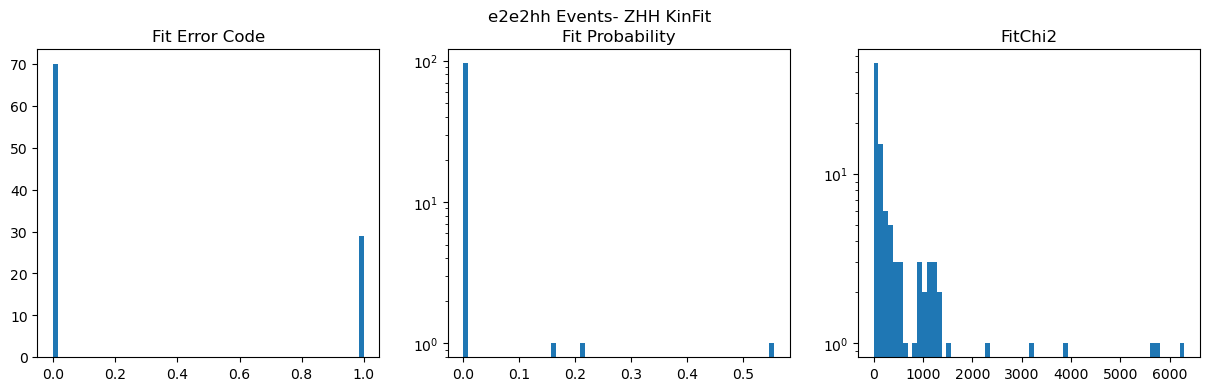

In [74]:
kwargs = { 'bins': 64 }
mask = merged['FinalStates/process'].array() == zhh.ProcessCategories.e2e2hh

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))
ax1.hist(merged[f'KinFitLL_ZHH']['FitErrorCode'].array()[mask], **kwargs)
ax1.set_title('Fit Error Code')

ax2.hist(merged[f'KinFitLL_ZHH']['FitProbability'].array()[mask], **kwargs)
ax2.set_yscale('log')
ax2.set_title('Fit Probability')

ax3.hist(merged[f'KinFitLL_ZHH']['FitChi2'].array()[mask], **kwargs)
ax3.set_yscale('log')
ax3.set_title('FitChi2')

fig.suptitle('e2e2hh Events- ZHH KinFit')

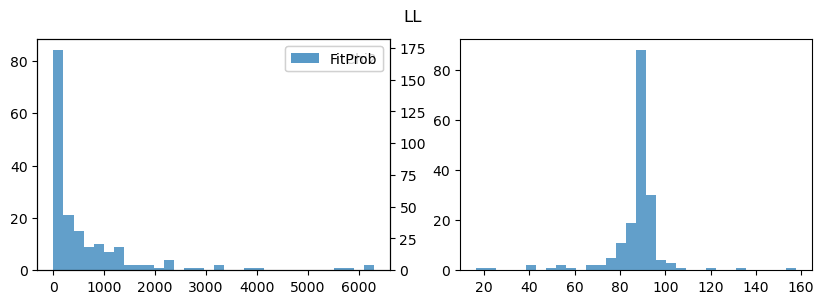

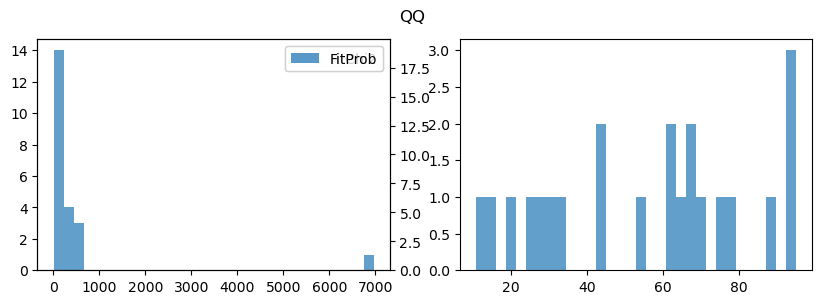

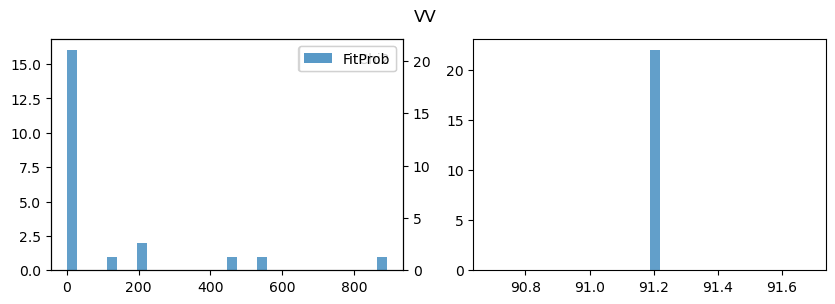

In [57]:
kwargs = {
    'bins': 32,
    'alpha': 0.7,
}

for ps, nisol in [
    ('LL', 2),
    ('QQ', 0),
    ('VV', 0)
]:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
    mask = np.array(merged[f'KinFit{ps}_ZHH']['nIsoLeptons'].array() == nisol)

    ax1.hist(merged[f'KinFit{ps}_ZHH']['FitChi2'].array()[mask], label='FitChi2', **kwargs )
    ax12 = ax1.twinx()
    ax12.hist(merged[f'KinFit{ps}_ZHH']['FitProbability'].array()[mask], label='FitProb', **kwargs )
    
    ax2.hist(merged[f'KinFit{ps}_ZHH']['Boson1BeforeFit'].array()[mask], label='Boson1BeforeFit', **kwargs )
    #ax2.hist(merged[f'KinFit{ps}_ZHH']['FitChi2'].array()[mask], label='FitChi2', **kwargs )
    #ax.hist(merged['KinFitLL_NMC']['Boson1AfterFit'].array()[mask], label='with mask', **kwargs)
    ax1.legend()
    ax12.legend()
    fig.suptitle(f'{ps}')
    plt.show()

In [ ]:
B1After = np.array(merged['KinFitLL_NMC']['Boson1AfterFit'].array())
FitCode = np.array(merged['KinFitLL_NMC']['FitErrorCode'].array())

In [51]:
FitCode[B1After == 0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [45]:
merged['KinFitLL_NMC']['Boson2AfterFit'].array()

<Array [300, 286, 147, 0, 0, ..., 262, 244, 135, 281, 0] type='198 * float32'>

(array([ 22.,   2.,   2.,   4.,   9., 144.,  12.,   1.,   1.,   1.]),
 array([  0.        ,  15.79172707,  31.58345413,  47.37517929,
         63.16690826,  78.95863342,  94.75035858, 110.54208374,
        126.33381653, 142.12553406, 157.91726685]),
 <BarContainer object of 10 artists>)

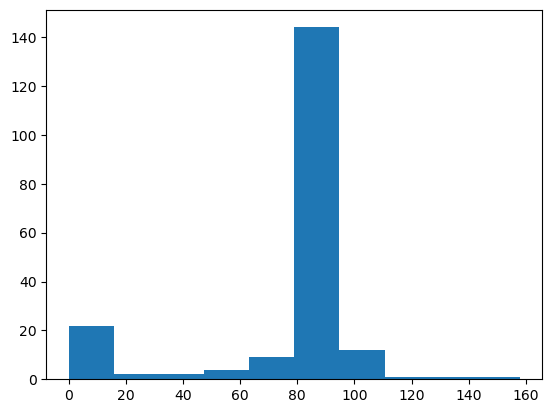

In [ ]:
plt.hist(merged['EventObservablesLL']['mzll'].array())

In [ ]:
zhh_cuts('ll')

[<Cut on nisoleps >= 2>,
 <Cut on 71.2 <= m_{Z} <= 111.2>,
 <Cut on 60.0 <= m_{H1} <= 180.0>,
 <Cut on 60.0 <= m_{H2} <= 180.0>,
 <Cut on p_{t}^{miss} <= 70.0>,
 <Cut on thrust <= 0.9>]

In [49]:
data_all = fetch_preselection_data('/home/ilc/bliewert/DevRepositories/ZHH/scripts/target.root')
data = data_all

for cut in zhh_cuts('ll'):
    print(f'length = {len(data)} prior to', cut)
    data = data[cut(data)]
    
mask = np.ones(len(data_all), dtype=bool)
mask[~np.isin(data_all['event'], data['event'])] = False

length = 198 prior to <Cut on nisoleps >= 2>
length = 177 prior to <Cut on 71.2 <= m_{Z} <= 111.2>
length = 162 prior to <Cut on 60.0 <= m_{H1} <= 180.0>
length = 159 prior to <Cut on 60.0 <= m_{H2} <= 180.0>
length = 153 prior to <Cut on p_{t}^{miss} <= 70.0>
length = 59 prior to <Cut on thrust <= 0.9>


In [ ]:
def prepare_presel_data(input, hypothesis:str):
    dtypes = []
        
    if hypothesis == '':
        
    return np.array()

In [ ]:
LL3 = AnalysisChannel('ZZH, ZZZ', [
    'EventObservablesLL/me_zhh_log',
    'EventObservablesLL/me_zzh_log',
    
    # KinFit ZHH
    'KinFitLL_ZHH/FitErrorCode',
    'KinFitLL_ZHH/Boson2AfterFit',
    'KinFitLL_ZHH/Boson3AfterFit',
    'KinFitLL_ZHH/p1stAfterFit',
    'KinFitLL_ZHH/FitChi2',
    'KinFitLL_ZHH/FitProbability',
    
    # KinFit ZZH
    'KinFitLL_ZZH/FitErrorCode',
    'KinFitLL_ZZH/Boson2AfterFit',
    'KinFitLL_ZZH/Boson3AfterFit',
    'KinFitLL_ZZH/p1stAfterFit',
    'KinFitLL_ZZH/FitChi2',
    'KinFitLL_ZZH/FitProbability',
    
    # KinFit ZZZ
    'KinFitLL_ZZZ/FitErrorCode',
    'KinFitLL_ZZZ/Boson2AfterFit',
    'KinFitLL_ZZZ/Boson3AfterFit',
    'KinFitLL_ZZZ/p1stAfterFit',
    'KinFitLL_ZZZ/FitChi2',
    'KinFitLL_ZZZ/FitProbability',
],
    define_sig=lambda data: np.isin(np.array(data['FinalStates/process'].array()), [zhh.ProcessCategories.e1e1hh, zhh.ProcessCategories.e2e2hh]),
    define_bkg=lambda data: np.isin(np.array(data['FinalStates/process'].array()), [zhh.ProcessCategories.e1e1qqh, zhh.ProcessCategories.e2e2qqh]))

<TBranch 'me_zhh_log' at 0x7fbc49d37d90>

In [19]:
sig['EventObservablesLL/me_zzh_log']

<TBranch 'me_zzh_log' at 0x7fbc49d36790>

In [6]:
from zhh import ProcessIndex

In [ ]:
ProcessIndex()

In [5]:
sig.keys()

['EventObservablesQQ;1',
 'KinFitQQ_ZZZ;2',
 'KinFitQQ_ZZZ;1',
 'KinFitQQ_ZZH;2',
 'KinFitQQ_ZZH;1',
 'KinFitQQ_ZHH;2',
 'KinFitQQ_ZHH;1',
 'KinFitQQ_NMC;2',
 'KinFitQQ_NMC;1',
 'EventObservablesVV;1',
 'KinFitVV_ZZZ;2',
 'KinFitVV_ZZZ;1',
 'KinFitVV_ZZH;2',
 'KinFitVV_ZZH;1',
 'KinFitVV_ZHH;2',
 'KinFitVV_ZHH;1',
 'KinFitVV_NMC;2',
 'KinFitVV_NMC;1',
 'EventObservablesLL;1',
 'KinFitLL_ZZZ;2',
 'KinFitLL_ZZZ;1',
 'KinFitLL_ZZH;2',
 'KinFitLL_ZZH;1',
 'KinFitLL_ZHH;2',
 'KinFitLL_ZHH;1',
 'KinFitLL_NMC;2',
 'KinFitLL_NMC;1',
 'SLDCorrection;4',
 'SLDCorrection;3',
 'SLDCorrection;2',
 'SLDCorrection;1',
 'SLDStatus;4',
 'SLDStatus;3',
 'SLDStatus;2',
 'SLDStatus;1',
 'BHadronType;4',
 'BHadronType;3',
 'BHadronType;2',
 'BHadronType;1',
 'CHadronType;4',
 'CHadronType;3',
 'CHadronType;2',
 'CHadronType;1',
 'PxResidual;8',
 'PxResidual;7',
 'PxResidual;6',
 'PxResidual;5',
 'PxResidual;4',
 'PxResidual;3',
 'PxResidual;2',
 'PxResidual;1',
 'PyResidual;8',
 'PyResidual;7',
 'PyResidua

In [19]:
rf['FinalStates'].keys()

['run',
 'event',
 'error_code',
 'final_states',
 'final_state_counts',
 'final_state_counts/final_state_counts.first',
 'final_state_counts/final_state_counts.second',
 'process',
 'event_category',
 'event_category_zhh',
 'n_fermion',
 'n_higgs',
 'n_b_from_higgs',
 'n_c_from_higgs']

In [ ]:
fsc = np.array(rf['FinalStates']['final_state_counts.second'].array())
nb = fsc[:, 4]

In [132]:
#is_signal = np.array(rf['FinalStates']['n_b_from_higgs'].array() == 4)
#is_signal = np.array(rf['FinalStates']['n_b_from_higgs'].array() == 4)
is_signal = nb == 4

In [133]:
is_signal.nbytes

3989121

In [66]:
PDGs = np.array(rf['FinalStates']['final_state_counts.first'].array(entry_start=0, entry_stop=1))
PDGs

array([[ 1,  2,  3,  4,  5,  6, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24,
        25]], dtype=int32)

In [83]:
np.unique(nb, return_counts=True)

(array([0, 1, 2, 3, 4, 6], dtype=int32),
 array([ 915880,     638, 1901912,     866,  998318,  171507]))

In [78]:
proc = np.array(rf['FinalStates']['process'].array())

In [79]:
proc

array([1511, 1511, 1511, ..., 2520, 2520, 2520], dtype=int32)